# Lesson 0029 - Deutsche Lufthansa Time Series Prediction Recurrent Neural Network
In the last three lessons, we tried to model the stock price of APPLE using recurrent neural networks.<br>
We achieved a decent performance in [lesson 0027](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0027_apple_time_series_prediction_recurrent_neural_network_2.ipynb), but we noticed, that the model has problems predicting values it has never seen before.<br>
In this lesson, we basically recreate [lesson 0027](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0027_apple_time_series_prediction_recurrent_neural_network_2.ipynb), but this time, we consider the stock price of Deutsche Lufthansa, because the stock price of Lufthansa of the last year is contained within the range of Lufthansa's stock price from the $4$ years before last year, which means, that the model does not have to predict unseen values.<br>
Therefore, we steal the code from [lesson 0027](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0027_apple_time_series_prediction_recurrent_neural_network_2.ipynb), and we only change the code where we download the Lufthansa stock data.

In [1]:
import tensorflow as tf

tf.set_random_seed( 1234567890 )

print( tf.__version__ )

1.13.1


In [2]:
import numpy as np

np.random.seed( 1234567890 )

print( np.__version__ )

1.16.2


In [3]:
import matplotlib
import matplotlib.pyplot as plt

print( matplotlib.__version__ )

3.0.3


In [4]:
import yfinance as yf 

print( yf.__version__ )

0.1.43


In [5]:
import datetime as dt

In [6]:
end = dt.datetime.now().strftime('%Y-%m-%d')

start = dt.datetime.now().strftime('%Y-%m-%d')




start_year = start[ 0 : 4 ]

start_year = int( start_year )

start_year = start_year - 5

start_year = str( start_year )

start = start_year + start[ 4 : len( start ) ] 



data = yf.download( 'LHA.DE', start, end )

[*********************100%***********************]  1 of 1 downloaded


C:\Users\rhopi\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Price ($)')

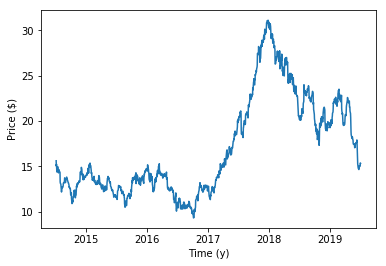

In [7]:
plt.plot( data.Close )

plt.xlabel( 'Time (y)' )

plt.ylabel( 'Price ($)' )

In [8]:
prices = data.Close.values

train = prices[ 0 : 1000 ]

test = prices[ 1000 : len( prices ) ]

In [9]:
mu = np.mean( train )

sigma = np.std( train )


train = ( train - mu ) / sigma

test = ( test - mu ) / sigma

In [10]:
x_tf = tf.placeholder( tf.float32, shape = [ None, 32, 1 ] )

y_tf = tf.placeholder( tf.float32, shape = [ None, 1 ] )



lstm1 = tf.nn.rnn_cell.LSTMCell( 256, state_is_tuple = True )

lstm1_out, _ = tf.nn.dynamic_rnn( lstm1, x_tf, dtype = tf.float32 )

lstm1_out2 = lstm1_out[ :, -1, : ]



W_tf = tf.Variable( tf.truncated_normal( [ 256, 1 ] ) )

b_tf = tf.Variable( tf.truncated_normal( [ 1 ] ) )

output = tf.matmul( lstm1_out2, W_tf ) + b_tf

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.


In [11]:
denominator = tf.math.reduce_sum( ( y_tf - tf.math.reduce_mean( y_tf ) ) ** 2 )

r_squared = 1 - tf.math.reduce_sum( ( y_tf - output ) ** 2 ) / denominator

gd = tf.train.GradientDescentOptimizer( 0.0001 ).minimize( - r_squared )

In [12]:
train_x = np.zeros( shape = [ 967, 32, 1 ] )

train_y = np.zeros( shape = [ 967, 1 ] )

test_x = np.zeros( shape = [ 235, 32, 1 ] )

test_y = np.zeros( shape = [ 235, 1 ] )




for i in range( 967 ):
    
    train_x[ i, :, 0 ] = train[ i : ( i + 32 ) ]
    
    train_y[ i, : ] = train[ i + 32 ]
    
    
    
for i in range( 235 ):
    
    test_x[ i, :, 0 ] = test[ i : ( i + 32 ) ]
    
    test_y[ i, : ] = test[ i + 32 ]

In [13]:
sess = tf.Session()


sess.run( tf.global_variables_initializer() )



performance_train_current = []

performance_train_complete = []

performance_test = []

iterations = []




for i in range( 400000 ):
    
    random_integers = np.random.choice( range( 967 ), 100, replace = False )
                
    local_x = train_x[ random_integers, :, : ]
    
    local_y = train_y[ random_integers, : ]
    
    sess.run( gd, feed_dict = { x_tf : local_x, y_tf : local_y } )
    
    performance_train_current.append( sess.run( r_squared, feed_dict = { x_tf : local_x, y_tf : local_y } ) )

    performance_train_complete.append( sess.run( r_squared, feed_dict = { x_tf : train_x, y_tf : train_y } ) )

    performance_test.append( sess.run( r_squared, feed_dict = { x_tf : test_x, y_tf : test_y } ) )
    
    iterations.append( i )

Text(0, 0.5, 'R squared (-)')

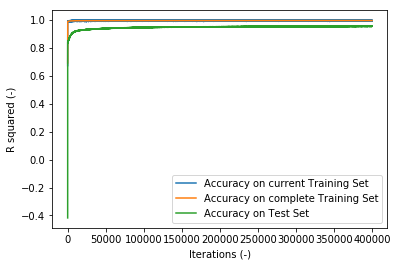

In [14]:
plt.plot( iterations, performance_train_current, label = 'Accuracy on current Training Set' )

plt.plot( iterations, performance_train_complete, label = 'Accuracy on complete Training Set' )

plt.plot( iterations, performance_test, label = 'Accuracy on Test Set' )

plt.legend( loc = 'best' )

plt.xlabel( 'Iterations (-)' )

plt.ylabel( 'R squared (-)' )

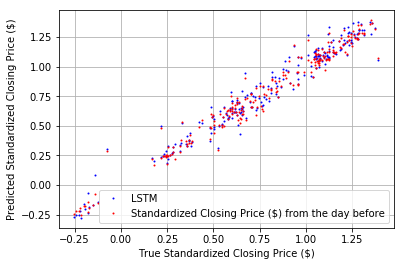

In [15]:
plt.plot( test_y, sess.run( output, feed_dict = { x_tf : test_x } ), 'bo', markersize = 1, label = 'LSTM' )

plt.plot( test_y, test_x[ :, 31 ], 'ro', markersize = 1, label = 'Standardized Closing Price ($) from the day before' )

plt.xlabel( 'True Standardized Closing Price ($)' )

plt.ylabel( 'Predicted Standardized Closing Price ($)' )

plt.legend( loc = 'best' )

plt.grid()

Text(0, 0.5, 'R squared (-)')

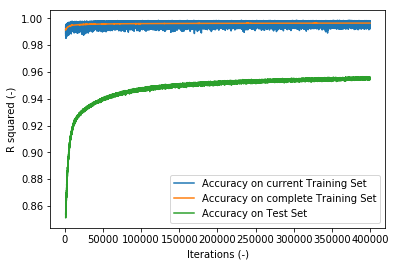

In [16]:
plt.plot( iterations[ 1000 : len( performance_train_current ) ], 
         performance_train_current[ 1000 : len( performance_train_current ) ], label = 'Accuracy on current Training Set' )

plt.plot( iterations[ 1000 : len( performance_train_current ) ],
         performance_train_complete[ 1000 : len( performance_train_current ) ], label = 'Accuracy on complete Training Set' )

plt.plot( iterations[ 1000 : len( performance_train_current ) ],
         performance_test[ 1000 : len( performance_train_current ) ], label = 'Accuracy on Test Set' )

plt.legend( loc = 'best' )

plt.xlabel( 'Iterations (-)' )

plt.ylabel( 'R squared (-)' )

Text(0, 0.5, 'R squared (-)')

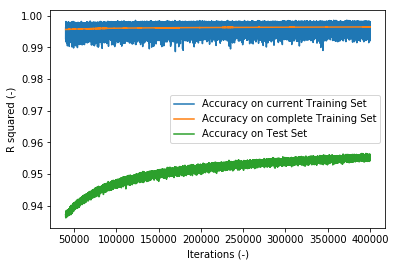

In [17]:
plt.plot( iterations[ 40000 : len( performance_train_current ) ], 
         performance_train_current[ 40000 : len( performance_train_current ) ], label = 'Accuracy on current Training Set' )

plt.plot( iterations[ 40000 : len( performance_train_current ) ],
         performance_train_complete[ 40000 : len( performance_train_current ) ], label = 'Accuracy on complete Training Set' )

plt.plot( iterations[ 40000 : len( performance_train_current ) ],
         performance_test[ 40000 : len( performance_train_current ) ], label = 'Accuracy on Test Set' )

plt.legend( loc = 'best' )

plt.xlabel( 'Iterations (-)' )

plt.ylabel( 'R squared (-)' )

In [18]:
sess.close()

We achieved a $R^{ 2 }$ value of $0.95$ which is pretty good, but the forecasts on the __test set__ vary around the true closing price as much as the closing price from the day before, so, even though we got a pretty good model, we should prefer the closing price from the day before.<br>
Class dismissed.